In [236]:
pip install torchtext==0.12.0

In [256]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [243]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [244]:
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [247]:
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

In [248]:
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")

In [252]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

Using device: cpu


4.1 and 4.2 baseline model

In [272]:
class BaselineModel(nn.Module):
    def __init__(self, vocab):
        super(BaselineModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.fc = nn.Linear(100, 1)

    def forward(self, x):
        embeddings = self.embedding(x)
        avg_embeddings = torch.mean(embeddings, dim=0)
        output = self.fc(avg_embeddings)
        return output

4.3 training loop

In [275]:
def train_baseline_model(model, train_dataloader, validation_dataloader, epochs=50, lr=0.001):

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # loss function
    criterion = nn.BCEWithLogitsLoss()

    # stores for plotting
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_x, batch_y in train_dataloader:
            # line below was auto gen (not sure why but it needed this on collab)
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()

            # forward
            outputs = model(batch_x)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, batch_y.float())

            # backward
            loss.backward()
            optimizer.step()

            # calc losses
            running_loss += loss.item()
            # the round function was also auto gen -> though there's some variability on stack over flow saying this works better
            preds = torch.round(torch.sigmoid(outputs))
            correct_predictions += (preds == batch_y).sum().item()
            total_predictions += batch_y.size(0)

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = correct_predictions / total_predictions

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # checking with val data
        val_loss, val_accuracy = evaluate_model(model, validation_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"[{epoch + 1}/{epochs}] Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # plots (generated using chatgpt)
    plt.figure(figsize=(12, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(np.arange(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(np.arange(1, epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # forward
            outputs = model(batch_x)
            outputs = outputs.squeeze(1)

            # losses
            loss = criterion(outputs, batch_y.float())
            running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct_predictions += (preds == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    val_loss = running_loss / len(dataloader)
    val_accuracy = correct_predictions / total_predictions

    return val_loss, val_accuracy


4.4 overfit test

[1/100] Train Loss: 1.0423, Train Accuracy: 0.6200 Validation Loss: 0.9800, Validation Accuracy: 0.5075
[2/100] Train Loss: 1.0096, Train Accuracy: 0.3200 Validation Loss: 0.8659, Validation Accuracy: 0.5075
[3/100] Train Loss: 0.8517, Train Accuracy: 0.3600 Validation Loss: 0.8034, Validation Accuracy: 0.5081
[4/100] Train Loss: 0.7693, Train Accuracy: 0.3800 Validation Loss: 0.7478, Validation Accuracy: 0.5131
[5/100] Train Loss: 0.7008, Train Accuracy: 0.5000 Validation Loss: 0.7031, Validation Accuracy: 0.5275
[6/100] Train Loss: 0.6456, Train Accuracy: 0.5400 Validation Loss: 0.6666, Validation Accuracy: 0.5444
[7/100] Train Loss: 0.5998, Train Accuracy: 0.6400 Validation Loss: 0.6368, Validation Accuracy: 0.5669
[8/100] Train Loss: 0.5611, Train Accuracy: 0.6400 Validation Loss: 0.6123, Validation Accuracy: 0.5900
[9/100] Train Loss: 0.5281, Train Accuracy: 0.7000 Validation Loss: 0.5919, Validation Accuracy: 0.6181
[10/100] Train Loss: 0.4993, Train Accuracy: 0.7200 Validation L

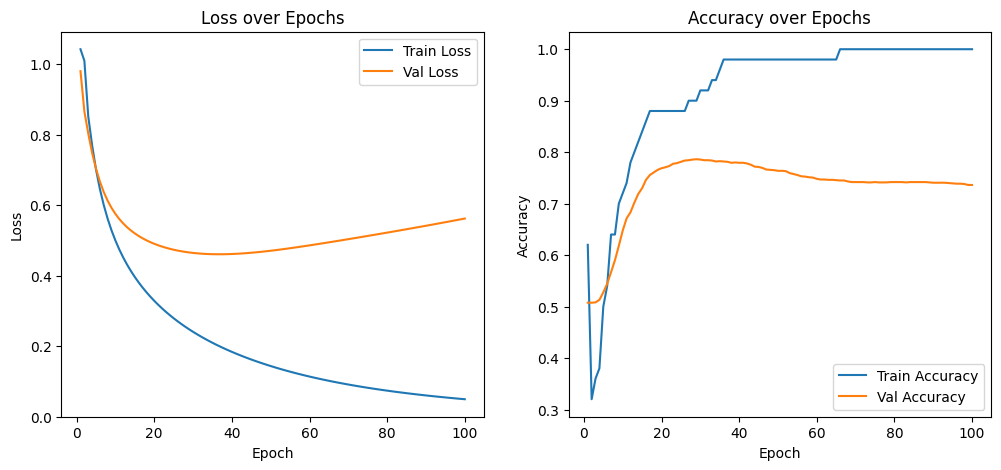

In [276]:
overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

model = BaselineModel(glove)

train_baseline_model(model, overfit_dataloader, validation_dataloader, epochs=100, lr=0.01)

[1/50] Train Loss: 0.6809, Train Accuracy: 0.5978 Validation Loss: 0.6666, Validation Accuracy: 0.7175
[2/50] Train Loss: 0.6521, Train Accuracy: 0.7163 Validation Loss: 0.6401, Validation Accuracy: 0.8094
[3/50] Train Loss: 0.6266, Train Accuracy: 0.7770 Validation Loss: 0.6167, Validation Accuracy: 0.8263
[4/50] Train Loss: 0.6040, Train Accuracy: 0.8048 Validation Loss: 0.5959, Validation Accuracy: 0.8387
[5/50] Train Loss: 0.5837, Train Accuracy: 0.8211 Validation Loss: 0.5772, Validation Accuracy: 0.8425
[6/50] Train Loss: 0.5655, Train Accuracy: 0.8295 Validation Loss: 0.5603, Validation Accuracy: 0.8456
[7/50] Train Loss: 0.5490, Train Accuracy: 0.8383 Validation Loss: 0.5451, Validation Accuracy: 0.8494
[8/50] Train Loss: 0.5341, Train Accuracy: 0.8430 Validation Loss: 0.5313, Validation Accuracy: 0.8500
[9/50] Train Loss: 0.5204, Train Accuracy: 0.8459 Validation Loss: 0.5187, Validation Accuracy: 0.8494
[10/50] Train Loss: 0.5080, Train Accuracy: 0.8481 Validation Loss: 0.507

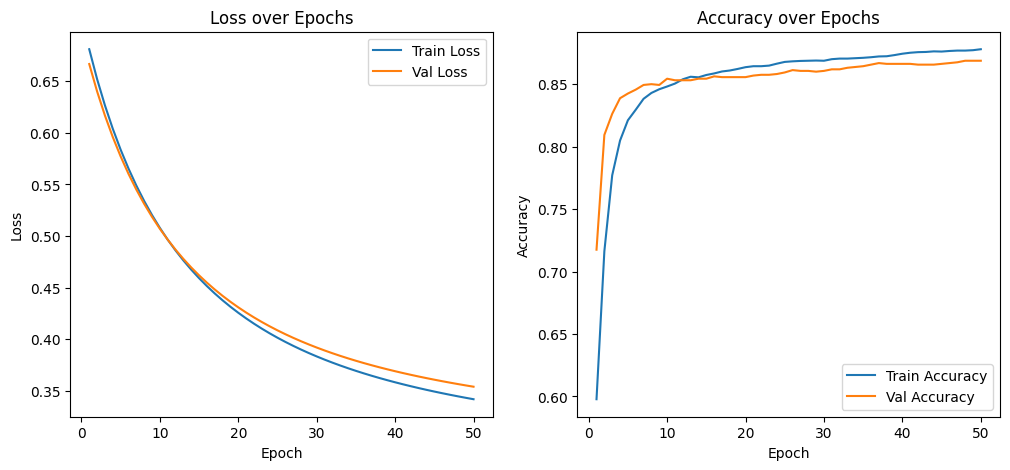

In [287]:
train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))


model = BaselineModel(glove)

train_baseline_model(model, train_dataloader, validation_dataloader, epochs=50, lr=0.001)

4.6 meaning extraction

In [283]:
weights = model.fc.weight.detach().cpu().numpy()
neuron_parameters = weights[0]
print(neuron_parameters)

[-2.7032757   1.5490162   0.4753274  -0.2356848  -1.4608535  -1.0754099
 -0.42090514 -0.30935755  0.2443041  -0.15039735  0.21075611 -1.8262438
 -0.57079256 -2.7368903   1.379932    1.1357772  -1.5506543   0.87587035
  1.8940538   0.39616007  0.44828227  0.1433144  -0.681339   -3.2597637
  0.32066315 -0.2440806   0.7547656   0.7315861  -2.6826303  -2.4202294
  0.8801999  -0.16017169 -1.6497169  -0.6480566   0.6290375   1.2803217
  0.96370864 -0.03218295 -1.4238933  -1.3020023   0.84917843  0.3240549
 -1.9106048   1.5387683  -0.24305663 -0.03562374  1.1916788  -0.5877864
 -0.9679792  -0.5065853   1.7781518  -0.23524065  0.23411264 -0.31168398
 -0.3692501  -0.10329379  3.2392492   0.77318066  0.10786614 -0.6016051
 -0.23878768  0.41666946 -1.8518616   0.1037299   0.13865    -1.5902547
  0.4664901  -0.4048544  -2.2703326  -1.591101    3.0687919   0.3092638
  1.4215661   1.0787781   0.3078896  -0.14542525 -0.32171747  0.03994205
  0.11241511 -0.41257367 -0.46680096 -0.5924816  -0.27834985 

In [284]:
def print_closest_cosine_words(vec, n=5):
    dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0), dim=1)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: -x[1])
    for idx, similarity in lst[1:n+1]:
        print(glove.itos[idx], "\t%5.2f" % similarity)

In [286]:
print_closest_cosine_words(torch.tensor(neuron_parameters), n=20)

visuals 	 0.57
realistic 	 0.55
disquieting 	 0.53
pleasing 	 0.53
insipid 	 0.53
cheesy 	 0.52
flattering 	 0.52
laughable 	 0.51
cartoonish 	 0.51
watchable 	 0.51
cartoony 	 0.50
ludicrous 	 0.50
refreshingly 	 0.50
encapsulates 	 0.50
escapist 	 0.50
portentous 	 0.50
refreshing 	 0.50
bracingly 	 0.50
gimmicky 	 0.50
campy 	 0.49


4.7 saving the model

In [288]:
torch.save(model.state_dict(), 'model_baseline.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')